# Quantum pseudo-telepathy: Mermin Peres Magic Square Game

Communication is bilateral. Without proper forms of communication many situations but also games cannot be resolved in the classical sense. TThe Mermin-Peres magic square game is an example of this. It was first proposed by Aravind in 2002, based on the work of Mermin, 1990 and Peres, 1990. It operates, as illustrated below, according to the following scheme: two players, Alice and Bob, play against a game master on a 3x3 grid. They not allowed to communicate. The game master chooses a row and assigns it to Bob and a column is assigned to Alice. 

The rules state that the number of tiles placed by Alice in the column must be either zero or two tiles and those placed by Bob in the row must be also either zero or two tiles. However, there must be unity with respect to the intersecting cell, between the row and the column and at least one tile of either player must be placed there. As we can see below, there are various cases when one of the two players places a tile incohrently (i.e. both play a tile in the intersecting cell) and the game is subsequeently lost, so there is no guarantee that the game can be won with a probability of 1. Formally, in a 3x3 grip there are 9 distinct cells, however as presented above the number of total tiles placed is even, as a result Alice and Bob can't agree on a non-overlapping strategy.

However, as an equilibrium strategy Alice and Bob can construct a 3x3 table, containing static examples of moves that can be played by them so that both of them win. However, a conflict between the winning conditions of Alice and Bob is bound to emerge, such that $\frac 8 {9}$ tiles can be placed without conflict. Consequently, the game has a winning probability of $\frac 8 {9}$.


<img src="Mirmin-Peres-Game/MPG.png" width="400"><br><br>Source: [Twisted Oaks](http://twistedoakstudios.com/blog/Post6536_implementing-quantum-pseudo-telepathy)

However, we can describe the game using a quantum mechanical system that gurantees to solve the game with a probability of 1. We methods such that it seems that Alice and Bob are communucating, hence the name Quantum pseudo-telepathy. This game has been [recently implemented] (https://medium.com/qiskit/this-proof-demonstrates-a-quantum-advantage-even-for-noisy-quantum-computers-b44a738801ad) and our aim is to explain it in detail and extend it to real quantum computers. In the orginal publication, rather than graphical tiles denoted with A & B as in the illustration above, conceptionally equivilant digits +1 and -1 are amployed for comptation. Hereafter, the tile B will be replaced by +1 and tile A by -1. 

To the end of implemenation, the Python Qiskit framework was employed. Subsequently, this notebook will introduce the quantum circuit solving the MPG game, provide a step-by-step walkthrough of the mathematical operation applied during an exemplary game and quantify it's performance on both simulated and real quantum computers. First, for the subsequent circuit definition, evaluation and illustration, we first have to define auxiliary functions and import the corresponding modules from Qiskit and Numpy

In [38]:
import numpy as np # comments
import random
import qiskit

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute, BasicAer, IBMQ, FakeVigo
from qiskit.providers.aer import QasmSimulator, UnitarySimulator
from qiskit.visualization import plot_state_qsphere
from qiskit.test.mock import FakeVigo
from qiskit.providers.ibmq import least_busy
from qiskit.ignis.mitigation.measurement import complete_meas_cal,CompleteMeasFitter 
from qiskit.visualization import plot_histogram 

ImportError: cannot import name 'FakeVigo' from 'qiskit' (/Users/david.drexlin@ibm.com/opt/anaconda3/lib/python3.8/site-packages/qiskit/__init__.py)

In [ ]:
#Comment

In [7]:
# function that sets up the initial entanglement between Alice and Bob
def share_bell_state(qc): 
    qc.h(0)
    qc.h(1)
    qc.cx(0,2)
    qc.cx(1,3)
    
# The following functions represent the U(gamma) and V(gamma) controlled Cliffords.
def U(qc,gamma):
    a = 0
    b = 1
    if gamma==1:
        qc.h(a)
        qc.i(b)

    elif gamma==2:
        qc.swap(a,b)
        qc.h(a)
        qc.i(b)

    elif gamma==3:
        qc.cx(a,b)
        qc.h(a)
        qc.i(b)

def V(qc,gamma):
    a = 2
    b = 3
    if gamma==1:
        qc.h(a)
        qc.h(b)

    if gamma==2:
        qc.swap(a,b)

    elif gamma==3:
        qc.z(a)
        qc.z(b)
        qc.cz(a,b)
        qc.h(a)
        qc.h(b)

In [3]:
#We will ask the user to select the row and column on Alice and Bob's behalf.
print("Alice and Bob, are assigned a column or row value of 1, 2, or 3") 
print("Alice assignment (column):")
alpha = random.randint(1, 4)
print("Bob assignment (row):")
beta = random.randint(1, 4)
print(alpha)
#Create the quantum register and the classical register to store our final bit values
q = QuantumRegister(4) # Alice-Qunatum Register (2) and Bob-Qunatum Register (2)
c = ClassicalRegister(4) 

#Create the circuit
magicsquare_circuit = QuantumCircuit(q,c)

#Generate the Bell state on the circuit
share_bell_state(magicsquare_circuit)
magicsquare_circuit.barrier()

#Draw the rest of the circuit based on Alice and Bob's selection   
if 4>alpha>0 and 4>beta>0:
    U(magicsquare_circuit,alpha) 
    V(magicsquare_circuit,beta)
    magicsquare_circuit.barrier()
    magicsquare_circuit.measure(q,c)
    
    magicsquare_circuit.draw(output='mpl')
    print(magicsquare_circuit)    
else:
    print("please enter values of 1, 2, or 3")

Alice and Bob, are assigned a column or row value of 1, 2, or 3
Alice assignment (column):
Bob assignment (row):
3


NameError: name 'share_bell_state' is not defined

In [ ]:
#Comment

In [5]:
#checks if the circuit output fulfills the winning criteria
def check_result(results, col, row):
    
    print_tut = True # variable governing printing of tutorial 
    expected_states = [] # array holding the answers used for accuracy  
    
    for i in results: 
        
        if print_tut: #prints explaination of transformation of the quantum circuit solution, for only the very first solution concept
            explain(i, col, row)
            print_tut = False

        print("Quantum circuit solution")
        print(i+"\n")
    
        i_orginal = i
        i = np.array(list(i.replace(" ", "")), dtype=np.int32)[::-1]
        
        # bring array in correct i.e. from incoming y2,y1,x2,x1 -> x1,x2,y1,y2
        a = i[0:2]
        a_sum = np.sum(a)
        a3 = int(np.mod(a_sum+1,2))
        a = np.append(a,a3)
        winning_alice = np.mod(a_sum + a3, 2) == 1
        # compute x3 by x1+x2+1 mod 2 and save to array

        b = i[2:]
        b_sum = np.sum(b)
        b3 = int(np.mod(b_sum,2))
        b = np.append(b,b3)
        winning_bob = np.mod(b_sum + b3, 2) == 0   
        # compute y3 by y1+y2 mod 2 and save to array

        # compute overall winning condition -> alice at index of bob's row and vice versa
        print("Alice's selection. Column:"+str(col)+"\n"+str(a.reshape(3,1))+"\n")
        print("Bob's circuit solution. Row:"+str(row)+"\n"+str(b)+"\n")
        
        if(winning_bob & winning_alice & (a[row-1]==b[col-1])):
            print("Victory!")    
            print("The following magic square wins the game!")
            print("\n")

            expected_states.append(str(i_orginal))
            k = np.empty((3,3,))
            k[:] = np.nan
            k[:,col-1] = a
            k[row-1,:] = b
            print(k)
        print("\n")
        print("------------------------------------------")  
        print("\n")
    return expected_states

In [6]:
# function explaining the computation of x3, y3 and presenting the corresponding winning moves
def explain(result, col, row):
    print("Resultant quantum circuit solution:"+"\n")
    print(result+"\n")
    example = np.array(list(result), dtype=np.int32)[::-1]
    print("Bring array in correct bit order i.e. from incoming y2,y1,x2,x1 -> x1,x2,y1,y2"+"\n")
    print(str(example)+"\n")
    print("Compute missing x3 with x1+x2+1 mod 2 for Alice and save to array for further processing")
    print("Compute missing y3 with y1+y2 mod 2 for Bob and save to array for further processing"+"\n")
   

    a = example[0:2]
    a_sum = np.sum(a)
    a3 = int(np.mod(a_sum+1,2))
    a = np.append(a,a3)
    winning_alice = np.mod(a_sum + a3, 2) == 1

    b = example[2:]
    b_sum = np.sum(b)
    b3 = int(np.mod(b_sum,2))
    b = np.append(b,b3)
    winning_bob = np.mod(b_sum + b3, 2) == 0   

    print(a.shape)
    print("Alice's column solution"+"\n"+str(a.reshape(3,1))+"\n" + "Winning conditions fullfilled (Odd quantitude of 1)?: "+str(winning_alice)+"\n")
    print("Bob's row solution"+"\n"+str(b)+"\n"+ "Winning conditions fullfilled (Even quantitude of 1)?: "+str(winning_bob)+"\n")
    print("Create matrix to show results"+"\n")
    k = np.empty((3,3,))
    k[:] = np.nan
    k[:,col-1] = a
    k[row-1,:] = b
    print(k)
    print("\n")
    print("------------------------------------------")  
    print("------------------------------------------")  
    print("\n")

In [ ]:
#Comment

In [ ]:
job = execute(magicsquare_circuit, BasicAer.get_backend('qasm_simulator'), optimization_level=3, shots=8192) # run the job simulation
results = job.result().get_counts()
print(results)
expected_states = check_result(results, alpha, beta)
print(state_accuracy)

#### Indeed, using an ideal quantum simulator, a winning probability of 100% is achieved, which exceeds the highest classical winning probability of 88.99% Beyond that, however, it is desirable to quantify the results on a real IBM quantum computer, which will be realized in the last section.

# Mathmatical background of the computation

As we have demonstrated above, the quantum circuit solves the Mirmin-Peres game (MPG) on simulators with a higher probability than with any classical strategy on ordinary computers possible. To shed some light on how and why this works, we present and explain the mathematical operations that lead to the solution of this game. In particular, we will first present a high-level equation describing the mathematical rationale and then we will take a look at each element of this equation explain it step by step.


Recall that the quantum circuit has to play different moves for each different row/column instances of the MPG being selected, since there is no classical strategy that can win the game with probability = 1. Thus, to win with probability 1, the quantum circuit dynamically adapts to the input of each column and row played. Nevertheless, there is indeed one part of the circuit that remains static and is responsible for generating a matching qubit state, that entangles the qubits of Alice and Bob. As this part comes prior to any adaptation we will start off by focusing on that part. 

![title](Mirmin-Peres-Game/Pauli_Operators.png)


These operators can then be translated into the [following quantum gates] (https://arxiv.org/pdf/1904.01502.pdf) for the r(spective row / column selected. To further understand why these Pauli operators are translated to the gates, see.: [Quantum advantage in noisy flat circuits](https://arxiv.org/pdf/1904.01502.pdf) 

![title](Mirmin-Peres-Game/Circuit_Operations.png)




Abstractly, then, as evident from the gates and the circuit above, see (a) & (b), the elements can be described by the following high-level formula:

$$ Quantum Solution MPG = Initial Vector * Dynamic Matrix(row, column)$$

#### Starting with the first part of the equation, the intial vector, of the MPG circuit is defined by quantum gates as follows:


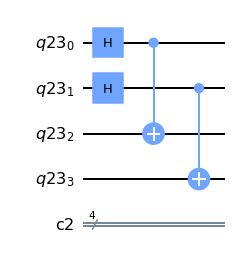

In [11]:
q = QuantumRegister(4) 
c = ClassicalRegister(4) 
qc = QuantumCircuit(q, c) 
share_bell_state(qc)
qc.draw(output='mpl')


#### This initial vector is generated, as illustrated above, by the application of two Hadamard gates to the first and second qubits and CNOT gates, with the first and second qubits serving as the control qubit and the third and fourth qubits, respectively, serving as the target qubit. Mathematically, these operations can be described by the following equation: 

$$ Initial Vector = (I ⨂ CNOT_{0|2}) ⨂ (CNOT_{1|3} ⨂ I) * (I ⨂ I ⨂ H ⨂ H) * InitialQubits $$

<br>

#### However, prior to inserting the corresponding matrices into this equation, we introduce the relevant matrices needed for the computation. 

#### The very starting vector state of the MPG circuit, prior to any quantum gate interaction, corresponds to the Dirac bracket |0000> and is hence described by the following vector: 
$$ InitialQubits= {\begin{pmatrix} 1 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\ 0\end{pmatrix}}$$

#### In terms of the gates, these are the mathmatical represetations of the relevant gates illustrated above. 

$$
I = \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix}  
$$

$$
H = \frac 1 {\sqrt{2}} \begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix}
$$

$$
CNOT_{(i, i+2)} = \begin{pmatrix} 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\ 
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\ 
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\ 
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\ 
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\ 
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\ 
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\ 
\end{pmatrix}
$$
<br>
The "i" in CNOT(i, i+2) refers to the control qubit in the first instance and to the target qubit in the second instance under the condition that there are at least two qubits in between such as $CNOT_(1,3)$



#### Now we can recall the equation of the initial vectors and insert the matrices:

$$ Initial Vector = (I ⨂ CNOT_{0|2}) ⨂ (CNOT_{1|3} ⨂ I) * (I ⨂ I ⨂ H ⨂ H) * InitialQubits $$


$$
Inital Vector = \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix} ⨂ \begin{pmatrix} 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\ 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \end{pmatrix} ⨂ \begin{pmatrix} 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\ 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \end{pmatrix} \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix} *
\begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix} ⨂ \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix} ⨂ \frac 1 {\sqrt{2}} \begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix} ⨂ \frac 1 {\sqrt{2}} \begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix} 
*
{\begin{pmatrix} 1 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\ 0\end{pmatrix}}
$$

$$ 
Inital Vector = \begin{bmatrix}\ 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\end{bmatrix}\ ⨂ \begin {bmatrix}\ 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0  \\\end{bmatrix}\
*
\begin{pmatrix} 1 & 0 & 0 & 0\\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0\\ 0 & 0 & 0 & 1 \end{pmatrix} 

⨂ 

\frac 1 {2} \begin{pmatrix} 1 & 1 & 1 & 1\\ 1 & -1 & 1 & -1 \\ 1 & 1 & -1 & -1\\ 1 & -1 & -1 & 1 \end{pmatrix}
*
{\begin{pmatrix} 1 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\ 0\end{pmatrix}}
$$

$$ 
InitialVector = \begin{bmatrix}\ 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1  \\\ 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0  \\\ 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\end{bmatrix}\
*
\begin{bmatrix}\ \frac 1 {2} & \frac 1 {2} & \frac 1 {2} & \frac 1 {2} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ \frac 1 {2} & -\frac 1 {2} & \frac 1 {2} & -\frac 1 {2} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ \frac 1 {2} & \frac 1 {2} & -\frac 1 {2} & -\frac 1 {2} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ \frac 1 {2} & -\frac 1 {2} & -\frac 1 {2} & \frac 1 {2} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & \frac 1 {2} & \frac 1 {2} & \frac 1 {2} & \frac 1 {2} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & \frac 1 {2} & -\frac 1 {2} & \frac 1 {2} & -\frac 1 {2}& 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & \frac 1 {2} & \frac 1 {2} & -\frac 1 {2} & -\frac 1 {2} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & \frac 1 {2} & -\frac 1 {2} & -\frac 1 {2} & \frac 1 {2} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \frac 1 {2} & \frac 1 {2} & \frac 1 {2} & \frac 1 {2} & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \frac 1 {2} & -\frac 1 {2} & \frac 1 {2} & -\frac 1 {2} & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \frac 1 {2} & \frac 1 {2} & -\frac 1 {2} & -\frac 1 {2} & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \frac 1 {2} & -\frac 1 {2} & -\frac 1 {2} & \frac 1 {2} & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \frac 1 {2} & \frac 1 {2} & \frac 1 {2} & \frac 1 {2}  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \frac 1 {2} & -\frac 1 {2} & \frac 1 {2} & -\frac 1 {2}  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \frac 1 {2} & \frac 1 {2} & -\frac 1 {2} & -\frac 1 {2}  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \frac 1 {2} & -\frac 1 {2} & -\frac 1 {2} & \frac 1 {2} \\\end{bmatrix}\
*
{\begin{pmatrix} 1 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\ 0\end{pmatrix}}
$$

$$
=\begin{bmatrix}\ \frac 1 {2} & \frac 1 {2} & \frac 1 {2} & \frac 1 {2} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & \frac 1 {2} & -\frac 1 {2} & \frac 1 {2} & -\frac 1 {2} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \frac 1 {2} & \frac 1 {2} & -\frac 1 {2} & -\frac 1 {2} & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \frac 1 {2} & -\frac 1 {2} & -\frac 1 {2} & \frac 1 {2} \\\ 0 & 0 & 0 & 0 & \frac 1 {2} & \frac 1 {2} & \frac 1 {2} & \frac 1 {2} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ \frac 1 {2} & -\frac 1 {2} & \frac 1 {2} & -\frac 1 {2} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  \frac 1 {2} & \frac 1 {2} & -\frac 1 {2} & -\frac 1 {2}  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \frac 1 {2} & -\frac 1 {2} & -\frac 1 {2} & \frac 1 {2}& 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \frac 1 {2} & \frac 1 {2} & \frac 1 {2} & \frac 1 {2} & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \frac 1 {2} & -\frac 1 {2} & \frac 1 {2} & -\frac 1 {2}  \\\ \frac 1 {2} & \frac 1 {2} & -\frac 1 {2} & -\frac 1 {2} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & \frac 1 {2} & -\frac 1 {2} & -\frac 1 {2} & \frac 1 {2} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \frac 1 {2} & \frac 1 {2} & \frac 1 {2} & \frac 1 {2}  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \frac 1 {2} & -\frac 1 {2} & \frac 1 {2} & -\frac 1 {2} & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & \frac 1 {2} & \frac 1 {2} & -\frac 1 {2} & -\frac 1 {2} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ \frac 1 {2} & -\frac 1 {2} & -\frac 1 {2} & \frac 1 {2} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\end{bmatrix}\
*
{\begin{pmatrix} 1 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\ 0\end{pmatrix}}
$$
$$
= \begin{pmatrix} \frac 1 {2} \\0 \\0 \\0 \\0 \\\frac 1 {2} \\0 \\0 \\0 \\0 \\\frac 1 {2} \\0 \\0 \\0 \\ 0\\ \frac 1 {2}\end{pmatrix}
$$

#### This resulting vector holds the relevant qubit states that can be further considered and modified in the dynmaic part of the circuit so that valid winning condition can be created, these Qubit states are:
$$= \frac 1 {2} (|0000\rangle+|0101\rangle+|1010\rangle+|1111\rangle)$$


#### Furthermore, when analyzing the initial vector, it becomes apparent that when multiplying any matrix by it, only four relevenate cells per row in the multiplier remain open for consideration, since the others are all multiplied by 0 and thereby likewise drop of with 0% probability as a result. Thus, we can eliminate the majority of the entries whatsoever. As an example we have prepared the matrix below, and denoted all entries with an i, that have to be computed and all others that result in any case with 0 with -.

$$ = 
\begin{bmatrix}\ \color{red}{X} & - & - & - & - & \color{red}{X} & - & - & - & - & \color{red}{X} & - & - & - & - & \color{red}{X}  \\\ \color{red}{X} & - & - & - & - & \color{red}{X} & - & - & - & - & \color{red}{X} & - & - & - & - & \color{red}{X}  \\\ \color{red}{X} & - & - & - & - & \color{red}{X} & - & - & - & - & \color{red}{X} & - & - & - & - & \color{red}{X}  \\\ \color{red}{X} & - & - & - & - & \color{red}{X} & - & - & - & - & \color{red}{X} & - & - & - & - & \color{red}{X}  \\\ \color{red}{X} & - & - & - & - & \color{red}{X} & - & - & - & - & \color{red}{X} & - & - & - & - & \color{red}{X}  \\\ \color{red}{X} & - & - & - & - & \color{red}{X} & - & - & - & - & \color{red}{X} & - & - & - & - & \color{red}{X}  \\\ \color{red}{X} & - & - & - & - & \color{red}{X} & - & - & - & - & \color{red}{X} & - & - & - & - & \color{red}{X}  \\\ \color{red}{X} & - & - & - & - & \color{red}{X} & - & - & - & - & \color{red}{X} & - & - & - & - & \color{red}{X}  \\\ \color{red}{X} & - & - & - & - & \color{red}{X} & - & - & - & - & \color{red}{X} & - & - & - & - & \color{red}{X}  \\\ \color{red}{X} & - & - & - & - & \color{red}{X} & - & - & - & - & \color{red}{X} & - & - & - & - & \color{red}{X}  \\\ \color{red}{X} & - & - & - & - & \color{red}{X} & - & - & - & - & \color{red}{X} & - & - & - & - & \color{red}{X}  \\\ \color{red}{X} & - & - & - & - & \color{red}{X} & - & - & - & - & \color{red}{X} & - & - & - & - & \color{red}{X}  \\\ \color{red}{X} & - & - & - & - & \color{red}{X} & - & - & - & - & \color{red}{X} & - & - & - & - & \color{red}{X}  \\\ \color{red}{X} & - & - & - & - & \color{red}{X} & - & - & - & - & \color{red}{X} & - & - & - & - & \color{red}{X}  \\\ \color{red}{X} & - & - & - & - & \color{red}{X} & - & - & - & - & \color{red}{X} & - & - & - & - & \color{red}{X}  \\\ \color{red}{X} & - & - & - & - & \color{red}{X} & - & - & - & - & \color{red}{X} & - & - & - & - & \color{red}{X}  \\\end{bmatrix} 
*
\begin{pmatrix} \frac 1 {2} \\0 \\0 \\0 \\0 \\\frac 1 {2} \\0 \\0 \\0 \\0 \\\frac 1 {2} \\0 \\0 \\0 \\0 \\ \frac 1 {2}\end{pmatrix}
$$

Let us now take a look at an concrete example, which shows and proofs that only the Xth-columns are relevant for the subsequent computation. Since all other columns are multiplied by zero and thus remain zero:

$$
Winnning Plays= 
\begin{bmatrix}\ \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}& 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}& 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0 \end{bmatrix} * 
\begin{pmatrix} \frac 1 {2} \\0 \\0 \\0 \\0 \\\frac 1 {2} \\0 \\0 \\0 \\0 \\\frac 1 {2} \\0 \\0 \\0 \\0 \\ \frac 1 {2}\end{pmatrix}
$$

Multiplying each row element with each coloumn element yields the following results:

$$
= \frac 1 {\sqrt{8}}
$$


However, considering only the i-row entries yields precisely the same results:
$$
Winnning Plays= 
\begin{bmatrix}\ \frac 1 {\sqrt{8}} & - & - & - & - & \frac 1 {\sqrt{8}}& - & - & - & - & 0 & - & - & - & - & 0 \end{bmatrix} * 
\begin{pmatrix} \frac 1 {2} \\0 \\0 \\0 \\0 \\\frac 1 {2} \\0 \\0 \\0 \\0 \\\frac 1 {2} \\0 \\0 \\0 \\0 \\ \frac 1 {2}\end{pmatrix}
$$
$$
= \frac 1 {\sqrt{8}}
$$
#### And indeed, this idea is very powerful because it lets us visually see what outcomes may emerge as well asa better idea of which outcomes may fall off and which may be a win in the MPG. As long as postive result emerges the MPG is won, no matter the probability of that play occuring

### Now, in order to consider the later, dynamic, part of the equation we will have to select an example. In this case we have selected row: 1 and column: 1. The corresponding quantum circuit is as follows:

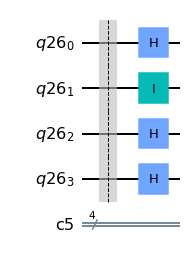

In [14]:
q = QuantumRegister(4) 
c = ClassicalRegister(4) 
qc = QuantumCircuit(q, c) 
qc.barrier()
U(qc,1) 
V(qc,1)
qc.draw(output='mpl')

#### The translation of these circuit gate operations is in turn equivalent to the following mathematical matrice multiplications:
$$ DynamicMatrix(1, 1) = H ⨂ H ⨂ I ⨂ H $$
$$
= \frac 1 {\sqrt{2}} \begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix} ⨂ \frac 1 {\sqrt{2}} \begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix} ⨂ \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix} ⨂ \frac 1 {\sqrt{2}} \begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix}
$$
$$
=
\begin{bmatrix}\ \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}& 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}& 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0  \\\ 
\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}& 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}& 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 
\\\ 
0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}  & 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}  
\\\
 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}  & 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} 
\\\ 
\frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}& 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}& 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0  
\\\ 
\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & -\frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}& 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}& 0 & 0 & -\frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0  
\\\ 
0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}  & 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}   
\\\ 
0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & -\frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}  & 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & -\frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} 
\\\
 \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}& 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}& 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0
  \\\
 \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}& 0 & 0 & -\frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}& 0 & 0 & -\frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0
  \\\ 
0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}  & 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} 
  \\\ 
0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}  & 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}
 \\\ 
\frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}& 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}& 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0  
\\\ 
\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & -\frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}& 0 & 0 & -\frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}& 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0
  \\\ 
0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}  & 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}  
 \\\ 
0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & -\frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}  & 0 & 0 & -\frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} \\\end{bmatrix}\ 
$$

#### Now, as we have both, the inital vector and the dynamic matrix, we can compute the winning plays for Alice and Bob with selected column and row of 1. In prinicple we can apply the rule of the i-rows, that we have established above, to this matrix-vector multiplication, however, in this case for the sake of completness we let all entries remain. But feel free to check the rule!

$$
Winning Plays = DynamicMatrix * InitialVector
$$
$$
= \begin{bmatrix}\ \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}& 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}& 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0  \\\ 
\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}& 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}& 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 
\\\ 
0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}  & 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}  
\\\
 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}  & 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} 
\\\ 
\frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}& 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}& 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0  
\\\ 
\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & -\frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}& 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}& 0 & 0 & -\frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0  
\\\ 
0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}  & 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}   
\\\ 
0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & -\frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}  & 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & -\frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} 
\\\
 \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}& 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}& 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0
  \\\
 \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}& 0 & 0 & -\frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}& 0 & 0 & -\frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0
  \\\ 
0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}  & 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} 
  \\\ 
0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}  & 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}
 \\\ 
\frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}& 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}& 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0  
\\\ 
\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & -\frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}& 0 & 0 & -\frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}& 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0
  \\\ 
0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}  & 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}  
 \\\ 
0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & -\frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}  & 0 & 0 & -\frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} \\\end{bmatrix}\ 
*
\begin{pmatrix} \frac 1 {2} \\0 \\0 \\0 \\0 \\\frac 1 {2} \\0 \\0 \\0 \\0 \\\frac 1 {2} \\0 \\0 \\0 \\ 0\\ \frac 1 {2}\end{pmatrix}
$$
$$
= \begin{pmatrix} \frac 1 {\sqrt{8}} \\0 \\\frac 1 {\sqrt{8}} \\0 \\0 \\\frac 1 {\sqrt{8}}  \\0 \\\frac 1 {\sqrt{8}}  \\\frac 1 {\sqrt{8}}  \\0 \\ -\frac 1 {\sqrt{8}}  \\0 \\0 \\\frac 1 {\sqrt{8}}  \\ 0\\ -\frac 1 {\sqrt{8}} \end{pmatrix}
$$


#### Finally, this vector contains the qubits that can be played to win the game with probability 1, these are:

$$= \frac 1 {\sqrt{8}} (|0000\rangle+|0100\rangle+|0101\rangle+|01111\rangle+|1000\rangle)-|1011\rangle)+|1101\rangle)-|1111\rangle)$$

#### To validate these mathematical results, we will run the quantum circuit in one go and compare the respective qubit results

In [ ]:
# function to calculate state accuracy
def get_state_accuracy(counts, expected_states, shots): 
    expected_counts = 0
    for state in counts.keys():
        if state in expected_states:
            expected_counts = expected_counts + counts[state]
    state_accuracy = expected_counts / shots
    return str(state_accuracy*100)+"%"

In [ ]:
#Comment

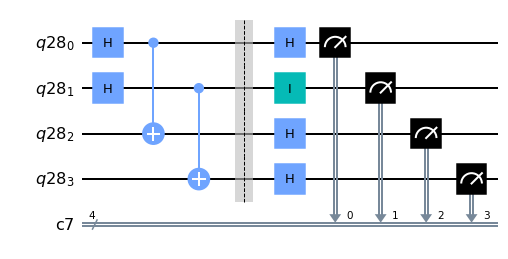

In [16]:
q = QuantumRegister(4) 
c = ClassicalRegister(4) 
qc = QuantumCircuit(q, c) 
share_bell_state(qc)
qc.barrier()
U(qc,1) 
V(qc,1)
qc.measure(q,c)
qc.draw(output='mpl')

In [17]:
backend = BasicAer.get_backend('qasm_simulator')
results = execute(qc, backend, optimization_level=3, shots=8192).result().get_counts()
expected_states = check_result(results, 1, 1)
state_accuracy = get_state_accuracy(results,expected_states,8192)
print("Accuracy: "+state_accuracy)

Resultant quantum circuit solution:

0000

Bring array in correct bit order i.e. from incoming y2,y1,x2,x1 -> x1,x2,y1,y2

[0 0 0 0]

Compute missing x3 with x1+x2+1 mod 2 for Alice and save to array for further processing
Compute missing y3 with y1+y2 mod 2 for Bob and save to array for further processing

(3,)
Alice's column solution
[[0]
 [0]
 [1]]
Winning conditions fullfilled (Odd quantitude of 1)?: True

Bob's row solution
[0 0 0]
Winning conditions fullfilled (Even quantitude of 1)?: True

Create matrix to show results

[[ 0.  0.  0.]
 [ 0. nan nan]
 [ 1. nan nan]]


------------------------------------------
------------------------------------------


Quantum circuit solution
0000

Alice's selection. Column:1
[[0]
 [0]
 [1]]

Bob's circuit solution. Row:1
[0 0 0]

Victory!
The following magic square wins the game!


[[ 0.  0.  0.]
 [ 0. nan nan]
 [ 1. nan nan]]


------------------------------------------


Quantum circuit solution
1111

Alice's selection. Column:1
[[1]
 [1]
 

#### Evidently, the results of the mathematical calculation match those of the circuit and a win rate of 100% is achieved!

------------------------------------------------------------------------------------------------------------------------------------------------------------------
To reproduce these operations for other configurations, it is recommended to use the Unitary simulator - follow this simple guide:

1. Install additional libararies: <br>
"!pip install "git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src""

2.  Imports libararies: <br>
from qiskit_textbook.tools import array_to_latex;
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, BasicAer;

3. Intialise a n-Qubit system and apply gates, an example 2-Qubit system: <br>
qc = QuantumCircuit(QuantumRegister(2) , ClassicalRegister(2)) <br>
result = execute(qc, BasicAer.get_backend('unitary_simulator')).result().get_unitary(qc) <br>
array_to_latex(result, pretext="\\text{Circuit = }\n") 
------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Circuit Performance on Real Quantum Devices

#### Thus far all executions of the Quantum circuits were performed on ideal quantum simulators, rather than actual quantum hardware. Real quantum computers have noise, decoherence and other periphery hardware issues, which can reduce the performance and fidelity of the executions. Hence, in order to ascertain the actucal performance and not only the theoretical we will execute our circuit on real quantum computers as well as simulators of real computers that include the above mentioned errors alike. 

#### We start off with the non-ideal simulators of the real quantum computers, so called FakeDevices. The use of FakeVigo, simualating the quantum Computer Vigo yields the following results.

In [24]:
job = execute(magicsquare_circuit, FakeVigo(), optimization_level=3, shots=8192) # run the job simulation
results = job.result().get_counts()
expected_states = check_result(results, alpha, beta)
state_accuracy = get_state_accuracy(results,expected_states,8192)
print(state_accuracy)

Resultant quantum circuit solution:

0000

Bring array in correct bit order i.e. from incoming y2,y1,x2,x1 -> x1,x2,y1,y2

[0 0 0 0]

Compute missing x3 with x1+x2+1 mod 2 for Alice and save to array for further processing
Compute missing y3 with y1+y2 mod 2 for Bob and save to array for further processing

(3,)
Alice's column solution
[[0]
 [0]
 [1]]
Winning conditions fullfilled (Odd quantitude of 1)?: True

Bob's row solution
[0 0 0]
Winning conditions fullfilled (Even quantitude of 1)?: True

Create matrix to show results

[[ 0.  0.  0.]
 [nan nan  0.]
 [nan nan  1.]]


------------------------------------------
------------------------------------------


Quantum circuit solution
0000

Alice's selection. Column:3
[[0]
 [0]
 [1]]

Bob's circuit solution. Row:1
[0 0 0]

Victory!
The following magic square wins the game!


[[ 0.  0.  0.]
 [nan nan  0.]
 [nan nan  1.]]


------------------------------------------


Quantum circuit solution
0001

Alice's selection. Column:3
[[1]
 [0]
 

#### We can oberserve that simulated noisy devices outperform classical systems and thus indicate that real quantum computers are capable of doing the same. Now in order to evaluate the performance of real devices we select the ibmq_athens computer to benchmark the MPG. Please note that you will have to add your own API token from the IBM Quantum website (https://quantum-computing.ibm.com) so that this cell executes

In [2]:
IBMQ.save_account('API_Key') # retrieve from your IBM-Account: https://quantum-computing.ibm.com

configrc.store_credentials:WARNING:2021-05-19 14:15:02,195: Credentials already present. Set overwrite=True to overwrite.


In [3]:
# load IBM Quantum Experience account 
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q') # get provider

/Users/david.drexlin@ibm.com/opt/anaconda3/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [69]:
job = execute(magicsquare_circuit, least_busy(provider.backends(simulator=False)),optimization_level=3, shots=8192)
results = job.result().get_counts()
expected_states = check_result(results, alpha, beta)
state_accuracy = get_state_accuracy(results,expected_states,8192)

Resultant quantum circuit solution:

0000

Bring array in correct bit order i.e. from incoming y2,y1,x2,x1 -> x1,x2,y1,y2

[0 0 0 0]

Compute missing x3 with x1+x2+1 mod 2 for Alice and save to array for further processing
Compute missing y3 with y1+y2 mod 2 for Bob and save to array for further processing

(3,)
Alice's column solution
[[0]
 [0]
 [1]]
Winning conditions fullfilled (Odd quantitude of 1)?: True

Bob's row solution
[0 0 0]
Winning conditions fullfilled (Even quantitude of 1)?: True

Create matrix to show results

[[ 0.  0.  0.]
 [nan nan  0.]
 [nan nan  1.]]


------------------------------------------
------------------------------------------


Quantum circuit solution
0000

Alice's selection. Column:3
[[0]
 [0]
 [1]]

Bob's circuit solution. Row:1
[0 0 0]

Victory!
The following magic square wins the game!


[[ 0.  0.  0.]
 [nan nan  0.]
 [nan nan  1.]]


------------------------------------------


Quantum circuit solution
0001

Alice's selection. Column:3
[[1]
 [0]
 

In [70]:
print(state_accuracy)

68.51806640625%


In [28]:
backend = provider.get_backend("ibmq_athens")

In [395]:
job = execute(magicsquare_circuit, backend,optimization_level=3, shots=8192) # run the job simulation with the highest compilter optimsation
results = job.result().get_counts()
expected_states = check_result(results, alpha, beta)
state_accuracy = get_state_accuracy(results,expected_states,8192)

In [396]:
state_accuracy

'96.69189453125%'

#### As shown above, the MPG circuit outperforms the classical circuit by about 7.8% (88.89% vs. 96.69%) on a real, noisy, quantum computer. Further optimising can be achieved via measurement error mitigation as can be further seen in this [notebook](https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html).

Resultant quantum circuit solution:

0000

Bring array in correct bit order i.e. from incoming y2,y1,x2,x1 -> x1,x2,y1,y2

[0 0 0 0]

Compute missing x3 with x1+x2+1 mod 2 for Alice and save to array for further processing
Compute missing y3 with y1+y2 mod 2 for Bob and save to array for further processing

(3,)
Alice's column solution
[[0]
 [0]
 [1]]
Winning conditions fullfilled (Odd quantitude of 1)?: True

Bob's row solution
[0 0 0]
Winning conditions fullfilled (Even quantitude of 1)?: True

Create matrix to show results

[[ 0.  0.  0.]
 [nan nan  0.]
 [nan nan  1.]]


------------------------------------------
------------------------------------------


Quantum circuit solution
0000

Alice's selection. Column:3
[[0]
 [0]
 [1]]

Bob's circuit solution. Row:1
[0 0 0]

Victory!
The following magic square wins the game!


[[ 0.  0.  0.]
 [nan nan  0.]
 [nan nan  1.]]


------------------------------------------


Quantum circuit solution
0001

Alice's selection. Column:3
[[1]
 [0]
 

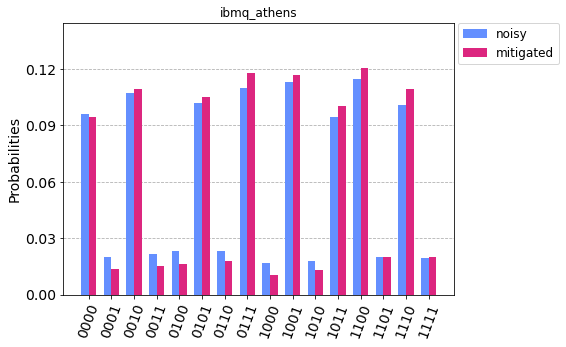

In [32]:
# measurement error mitigation on backend 1
results_backend1_mem = []

# normal execution
noisy_counts = execute(magicsquare_circuit, backend=backend, shots=8192, optimization_level=0).result().get_counts() # get results
expected_states = check_result(noisy_counts, alpha, beta)
state_accuracy = get_state_accuracy(noisy_counts,expected_states,8192)
results_backend1_mem.append(("noisy", noisy_counts, state_accuracy))

# measurement error mitigation
qr = QuantumRegister(4)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal') # setup calibration measures on basis states

cal_results = execute(meas_calibs, backend=backend, shots=8192).result() # execute calibration measures
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
meas_filter = meas_fitter.filter # get the filter object from calibration

mitigated_counts = meas_filter.apply(noisy_counts) # apply filter to get mitigated results
expected_states = check_result(mitigated_counts, alpha, beta)
state_accuracy = get_state_accuracy(mitigated_counts,expected_states,8192)
results_backend1_mem.append(("mitigated", mitigated_counts, state_accuracy))

# compare state accuracies
print("State Accuracy \n"+
      "\n".join([str(label)+': '+str(state_accuracy) for label, counts, state_accuracy in results_backend1_mem]))

# plot results
plot_histogram([counts for optim_level, counts, state_accuracy in results_backend1_mem],
               legend=[label for label, counts, state_accuracy in results_backend1_mem],
               title=backend.name(),
               bar_labels=False)

#### The noisy could be reduced in this experiment by further 4%, however, the orginal results could not be reconstricuted and thus attained or surpassed. At this point, if running this notebook on a shared system (e.g. mybinder.org), remember to log off from your IBM Q account in case you used it for execution on real devices by running the following cell:

In [ ]:
IBMQ.disable_account()
IBMQ.delete_account()

#### Finally, this conclues our experiments conducted with respect to the Mermin Peres Magic Sqaure Game, we elaborated the quantum architecure of the game, presented its mathmatical scheme of operation and quantified the results on real quantum computers. 

_Respectfully,
Dr. Jan-Rainer Lahmann - David Drexlin_